In [1]:
from neurotron import Attribute, Matrix, Field, Collab, Excite, Predict, Terminal, Cluster,Token
from neurotron import isa,rand,sum,zeros,ones,row,column,min,max,seed, AND, OR, NOT, all


In [ ]:
#===========================================================================
# helper: check cell's movie with given pattern
#===========================================================================

def check(cells,pattern):
    """
    check(): check recorder pattern of a network of cells against a given
             pattern and raise exception if check fails.
    >>> par,token = toy('sarah')
    >>> cells = Cells(3,par,[3,10])
    >>> y = cells.iteration([0,0,0]+token['Sarah'])
    >>> check(cells,'|U,U,QB,QBY,DY,D--|---D,XD,X,X,X|---D,D---|')
    """
    p = cells.record.pattern()
    if p != pattern:
        print('expected: ',pattern)
        print('got:      ',p)
        raise Exception('pattern check failed')



In [2]:
class Cells(Cluster):
    def __init__(self,token):
        shape = (2,9,2,5);  seed(1)
        cells = super().__init__(*shape,verbose=1)
        self.token = token
        m,n,d,s = shape
        self.y = row(zeros(1,m*n),token['Mary'])

    def process(self,word,all=None):
        m,n,d,s = self.shape
        self.y = row(zeros(1,m*n),token[word])
        self.y = self.apply(self.y,word,all=all)

    def predictive(self,list):
        for k in list:
            cells.X[k] = 1;
            cells._predict.I[k] = Matrix([[.1,-.1,.1,-.1,.1],[0,0,0,0,0]])
        
token = Token({'Mary': [1,0,0,0,0,0,0,1,1],
               'John': [0,1,0,0,0,0,0,1,1],
               'likes':[0,0,1,0,0,0,0,1,1],
               'to':   [0,0,0,1,0,0,0,1,1],
               'sing': [0,0,0,0,1,0,0,1,1],
               'dance':[0,0,0,0,0,1,0,1,1],
               '.':    [0,0,0,0,0,0,1,1,1],
               })

cells = Cells(token)
    

learn P[1]: [0.5 0 0.25 0.1 0.45; 0.95 0.1 0.35 1 0.75] by [0.1 -0.1 0.1 -0.1 0.1; 0 0 0 0 0]
learn P[14]: [1 0.25 0.6 0.45 0.8; 0.3 0.15 0.1 0.6 0.3] by [0.1 -0.1 0.1 -0.1 0.1; 0 0 0 0 0]


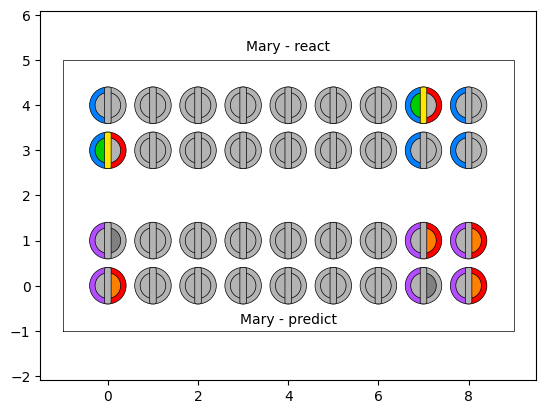

In [3]:
cells.predictive([1,14])
cells.process('Mary')

In [5]:
cells.state

<bound method Cluster.state of <__main__.Cells object at 0x118ba7b10>>